In [5]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 

In [46]:
from audtorch.metrics.functional import pearsonr as correlation

tensor(-0.0049)

In [6]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

train_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=True
)

test_set = MNIST(
    './', 
    download=True,
    transform=transforms.ToTensor(), 
    train=False
)

--2021-10-09 09:49:01--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-10-09 09:49:02--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  6.33MB/s    in 5.8s    

2021-10-09 09:49:08 (5.76 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=128, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=128, shuffle=False,drop_last=True)

In [8]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 48, kernel_size=3), nn.ReLU(),
        nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(48, 96, kernel_size=3), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 96, kernel_size=1, stride=1, padding=1), nn.ReLU(),
        nn.Conv2d(96, 10, kernel_size=1), 
        nn.AvgPool2d(kernel_size=8),
    )
  def forward(self, x):
    logits = self.net(x)
    return logits.view(-1, 10)

In [9]:
# Pretrain classifier
classifier = Classifier().cuda()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()
for epoch in range(20):
  for i, (x,y) in enumerate(train_loader):
    x, y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    train_loss = loss(classifier(x), y)
    train_loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Classifier_loss: {}'.format(epoch+1, 20, i+1, len(train_loader), train_loss.item()))

Epoch [1/20], Step [1/469], Classifier_loss: 2.2872812747955322
Epoch [1/20], Step [101/469], Classifier_loss: 1.0859849452972412
Epoch [1/20], Step [201/469], Classifier_loss: 0.40757670998573303
Epoch [1/20], Step [301/469], Classifier_loss: 0.45537304878234863
Epoch [1/20], Step [401/469], Classifier_loss: 0.12363621592521667
Epoch [2/20], Step [1/469], Classifier_loss: 0.2408977895975113
Epoch [2/20], Step [101/469], Classifier_loss: 0.2142801284790039
Epoch [2/20], Step [201/469], Classifier_loss: 0.15665756165981293
Epoch [2/20], Step [301/469], Classifier_loss: 0.10325092822313309
Epoch [2/20], Step [401/469], Classifier_loss: 0.1846301406621933
Epoch [3/20], Step [1/469], Classifier_loss: 0.1308719664812088
Epoch [3/20], Step [101/469], Classifier_loss: 0.08456376194953918
Epoch [3/20], Step [201/469], Classifier_loss: 0.07803798466920853
Epoch [3/20], Step [301/469], Classifier_loss: 0.07765834778547287
Epoch [3/20], Step [401/469], Classifier_loss: 0.05555925890803337
Epoch [

In [10]:
torch.save(classifier.state_dict(), 'pretrained_classifier.pth')

In [11]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy: %s %%' % (100 * correct / total))

In [20]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    layers = [
              nn.Conv2d(1, 64, 5, padding=2, stride=2), nn.BatchNorm2d(64, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(64, 128, 5, padding=2, stride=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Conv2d(128, 256, 5, padding=2, stride=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Flatten(), nn.Linear(256*4*4, 2048), nn.BatchNorm1d(2048, momentum=0.9), nn.LeakyReLU(0.2),
              nn.Linear(2048, 10),
    ]
    self.net = nn.Sequential(*layers)

  def forward(self,x):
    return self.net(x)

In [41]:
!pip install audtorch

     |████████████████████████████████| 54 kB 1.9 MB/s 


In [69]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
              nn.Linear(20, 256*4*4), nn.BatchNorm1d(256*4*4, momentum=0.9), nn.LeakyReLU(0.2),
              )
    self.conv = nn.Sequential(
        nn.ConvTranspose2d(256,256,6, stride=2, padding=2), nn.BatchNorm2d(256, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256,128,6, stride=2, padding=2), nn.BatchNorm2d(128, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128,32,6, stride=2, padding=3), nn.BatchNorm2d(32, momentum=0.9), nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(32,1,5, stride=1, padding=3), nn.Tanh()
    )

  def forward(self, x):
    x = self.linear(x)
    x = x.view(-1, 256, 4, 4)
    return self.conv(x)

In [77]:
class Generator(nn.Module):
  def __init__(self, epsilon):
    super().__init__()
    self.decoder = Decoder()
    self.encoder = Encoder()
    self.classifier = classifier
    self.epsilon = epsilon
    for param in classifier.parameters():
      param.requires_grad = False

  def loss(self, x, y, gen_labels):
    one_hot = F.one_hot(gen_labels).cuda()
    z = torch.cat((self.encoder(x), one_hot), 1)
    perturbation = epsilon * self.decoder(z)
    logits = self.classifier(x+perturbation)
    predictions = F.softmax(logits, 1)
    loss = nn.CrossEntropyLoss()
    return loss(classifier(x+perturbation), gen_labels), perturbation

In [91]:
epsilon = 0.25
epochs = 5
model = Generator(epsilon).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for epoch in range(epochs):
  for i, (x,y) in enumerate(train_loader):
    x,y = x.cuda(), y.cuda()
    optimizer.zero_grad()
    gen_labels = torch.randint(0,10, (128,)).cuda()
    loss, perturbation = model.loss(x,y,gen_labels)
    loss.backward()
    optimizer.step()
    if (i%100 == 0):
        print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))

Epoch [1/5], Step [1/468], Loss: 14.090855598449707
Epoch [1/5], Step [101/468], Loss: 3.68446946144104
Epoch [1/5], Step [201/468], Loss: 1.1466513872146606
Epoch [1/5], Step [301/468], Loss: 0.880957841873169
Epoch [1/5], Step [401/468], Loss: 0.41634470224380493
Epoch [2/5], Step [1/468], Loss: 0.3988185226917267
Epoch [2/5], Step [101/468], Loss: 0.4445189833641052
Epoch [2/5], Step [201/468], Loss: 0.4020090401172638
Epoch [2/5], Step [301/468], Loss: 0.4420362412929535
Epoch [2/5], Step [401/468], Loss: 0.447993665933609
Epoch [3/5], Step [1/468], Loss: 0.33039402961730957
Epoch [3/5], Step [101/468], Loss: 0.5245319604873657
Epoch [3/5], Step [201/468], Loss: 0.37577489018440247
Epoch [3/5], Step [301/468], Loss: 0.3633541762828827
Epoch [3/5], Step [401/468], Loss: 0.2386483997106552
Epoch [4/5], Step [1/468], Loss: 0.22802457213401794
Epoch [4/5], Step [101/468], Loss: 0.3210688531398773
Epoch [4/5], Step [201/468], Loss: 0.1934107542037964
Epoch [4/5], Step [301/468], Loss: 0

In [92]:
def adv_accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda(), y.cuda()
          gen_labels = torch.randint(0,10, (128,)).cuda()
          outputs = net(model.loss(images, labels, gen_labels)[1] + images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Adversarial accuracy: %s %%' % (100 * correct / total))

In [93]:
adv_accuracy(classifier)

Adversarial accuracy: 13.040865384615385 %


tensor([5, 2, 6, 5, 5, 8, 9, 5, 7, 7], device='cuda:0')


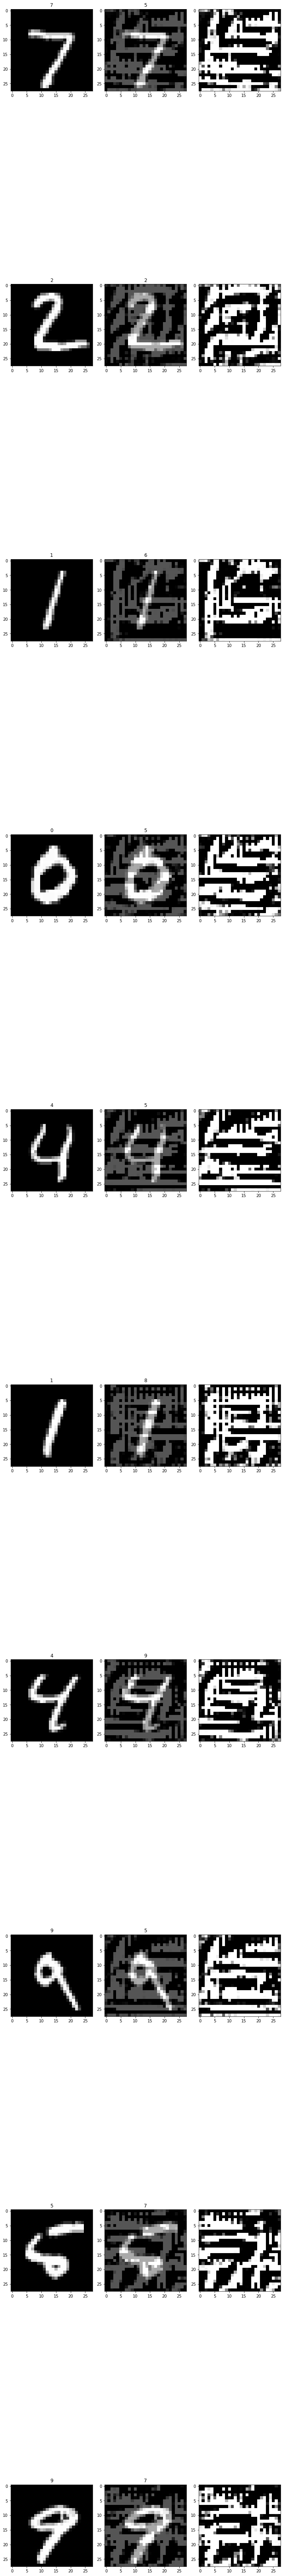

In [94]:
iterator = iter(test_loader)
x,y = next(iterator)
x, y = x.cuda(), y.cuda()
gen_labels = torch.randint(0,10, (128,)).cuda()
base_predictions = classifier(x)
_, perturbations = model.loss(x,y, gen_labels)
print(gen_labels[:10])
new_predictions = classifier(x+perturbations)
fig, axs = plt.subplots(10, 3)
fig.set_figheight(100)
fig.set_figwidth(10)
images = []
for i in range(10):
        image, perturbation = x[i][0].cpu().detach().numpy(), perturbations[i][0].cpu().detach().numpy()
        images.append(axs[i, 0].imshow(image, cmap='gray'))
        axs[i,0].title.set_text(torch.argmax(base_predictions[i]).item())
        images.append(axs[i,1].imshow(image+perturbation, cmap='gray'))
        axs[i,1].title.set_text(torch.argmax(new_predictions[i]).item())
        images.append(axs[i,2].imshow(perturbation, cmap='gray'))

plt.tight_layout()
plt.show()